In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 579ms/step - loss: 0.0776
Average validation loss: 0.6850649118423462
4/4 [==============================] - 6s 594ms/step - loss: 0.0776 - val_loss: 0.6851
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 566ms/step - loss: 0.0554 - val_loss: 0.6851
Average validation loss: 0.6365392208099365
4/4 [==============================] - 8s 578ms/step - loss: 0.0554 - val_loss: 0.6608
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 603ms/step - loss: 0.0419 - val_loss: 0.6608
Average validation loss: 0.5785816311836243
4/4 [==============================] - 10s 614ms/step - loss: 0.0419 - val_loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 686ms/step - loss: 3.8873e-05
Average validation loss: 0.0
8/8 [==============================] - 6s 695ms/step - loss: 3.8873e-05 - val_loss: 0.0000e+00
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 709ms/step - loss: 3.7057e-05 - val_loss: 0.0000e+00
Average validation loss: 7.271921065310494e-09
8/8 [==============================] - 11s 721ms/step - loss: 3.7057e-05 - val_loss: 3.6360e-09
Epoch 3/10
8/8 [==============================] - 17s 702ms/step - loss: 3.6570e-05 - val_loss: 3.6360e-09
Average validation loss: 1.7512887251491804e-09
8/8 [==============================] - 17s 714ms/step - loss: 3.6570e-05 - val_loss: 3.0077e-09
Epoch 4/10
8/8 [==============================] - 23s 700ms/step - loss: 3.6010e-05 - val_loss: 3.0077e-09
Average validation l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 703ms/step - loss: 8.9993e-05
Average validation loss: 0.051579013223317816
12/12 [==============================] - 9s 714ms/step - loss: 8.9993e-05 - val_loss: 0.0516
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 704ms/step - loss: 9.6607e-05 - val_loss: 0.0516
Average validation loss: 0.13313929736792338
12/12 [==============================] - 17s 713ms/step - loss: 9.6607e-05 - val_loss: 0.0924
Epoch 3/10
12/12 [==============================] - 26s 688ms/step - loss: 9.4312e-05 - val_loss: 0.0924
Average validation loss: 0.10629047504456086
12/12 [==============================] - 26s 699ms/step - loss: 9.4312e-05 - val_loss: 0.0970
Epoch 4/10
12/12 [==============================] - 34s 693ms/step - loss: 9.3447e-05 - val_loss: 0.0970
Average validation

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 701ms/step - loss: 5.1509e-05
Average validation loss: 0.04343713217349432
16/16 [==============================] - 11s 712ms/step - loss: 5.1509e-05 - val_loss: 0.0434
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 691ms/step - loss: 5.3834e-05 - val_loss: 0.0434
Average validation loss: 0.2594865506516726
16/16 [==============================] - 23s 702ms/step - loss: 5.3834e-05 - val_loss: 0.1515
Epoch 3/10
16/16 [==============================] - 34s 701ms/step - loss: 5.1406e-05 - val_loss: 0.1515
Average validation loss: 0.049600978961393594
16/16 [==============================] - 34s 712ms/step - loss: 5.1406e-05 - val_loss: 0.1175
Epoch 4/10
16/16 [==============================] - 45s 703ms/step - loss: 4.9517e-05 - val_loss: 0.1175
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 706ms/step - loss: 2.8033e-05
Average validation loss: 0.08311778290662915
20/20 [==============================] - 14s 716ms/step - loss: 2.8033e-05 - val_loss: 0.0831
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 712ms/step - loss: 2.5819e-05 - val_loss: 0.0831
Average validation loss: 0.021150260372087358
20/20 [==============================] - 29s 722ms/step - loss: 2.5819e-05 - val_loss: 0.0521
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 702ms/step - loss: 2.6181e-05 - val_loss: 0.0521
Average validation loss: 0.06213108165102312
20/20 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 696ms/step - loss: 3.3609e-05
Average validation loss: 0.031036679943402607
24/24 [==============================] - 17s 706ms/step - loss: 3.3609e-05 - val_loss: 0.0310
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 735ms/step - loss: 3.0265e-05 - val_loss: 0.0310
Average validation loss: 0.02445691917091608
24/24 [==============================] - 35s 744ms/step - loss: 3.0265e-05 - val_loss: 0.0277
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 51s 688ms/step - loss: 2.9037e-05 - val_loss: 0.0277
Average validation loss: 0.021773960751791794
24/24 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 31s 766ms/step - loss: 7.7482e-05
Average validation loss: 0.05483242031186819
40/40 [==============================] - 31s 778ms/step - loss: 7.7482e-05 - val_loss: 0.0548
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 62s 771ms/step - loss: 6.6441e-05 - val_loss: 0.0548
Average validation loss: 0.041833129711449146
40/40 [==============================] - 62s 781ms/step - loss: 6.6441e-05 - val_loss: 0.0483
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 93s 764ms/step - loss: 5.7783e-05 - val_loss: 0.0483
Average validation loss: 0.0287537076510489
40/40 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 37s 768ms/step - loss: 4.7384e-05
Average validation loss: 0.12170486079070801
48/48 [==============================] - 37s 778ms/step - loss: 4.7384e-05 - val_loss: 0.1217
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 74s 764ms/step - loss: 3.6107e-05 - val_loss: 0.1217
Average validation loss: 0.012907953137376657
48/48 [==============================] - 75s 775ms/step - loss: 3.6107e-05 - val_loss: 0.0673
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 111s 767ms/step - loss: 3.0169e-05 - val_loss: 0.0673
Average validation loss: 0.01933748904654446
48/48 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 694ms/step - loss: 6.6045e-05
Average validation loss: 0.018604282954973832
56/56 [==============================] - 39s 704ms/step - loss: 6.6045e-05 - val_loss: 0.0186
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 699ms/step - loss: 4.3747e-05 - val_loss: 0.0186
Average validation loss: 0.029594235142992278
56/56 [==============================] - 79s 709ms/step - loss: 4.3747e-05 - val_loss: 0.0241
Epoch 3/10
56/56 [==============================] - 119s 703ms/step - loss: 3.4864e-05 - val_loss: 0.0241
Average validation loss: 0.01710160845167203
56/56 [==============================] - 119s 713ms/step - loss: 3.4864e-05 - val_loss: 0.0218
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 703ms/step - loss: 3.0442e-05
Average validation loss: 0.040647091267601354
64/64 [==============================] - 46s 713ms/step - loss: 3.0442e-05 - val_loss: 0.0406
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 696ms/step - loss: 2.2487e-05 - val_loss: 0.0406
Average validation loss: 0.014851765597995836
64/64 [==============================] - 91s 707ms/step - loss: 2.2487e-05 - val_loss: 0.0277
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 135s 695ms/step - loss: 1.9368e-05 - val_loss: 0.0277
Average validation loss: 0.011475028928543907
64/64 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 694ms/step - loss: 2.4095e-05
Average validation loss: 0.020973352974073753
72/72 [==============================] - 51s 704ms/step - loss: 2.4095e-05 - val_loss: 0.0210
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 702ms/step - loss: 1.7482e-05 - val_loss: 0.0210
Average validation loss: 0.057708730093306966
72/72 [==============================] - 102s 712ms/step - loss: 1.7482e-05 - val_loss: 0.0393
Epoch 3/10
72/72 [==============================] - 152s 700ms/step - loss: 1.3726e-05 - val_loss: 0.0393
Average validation loss: 0.009918957483023405
72/72 [==============================] - 153s 710ms/step - loss: 1.3726e-05 - val_loss: 0.0295
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_06

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 55s 688ms/step - loss: 2.0714e-05
Average validation loss: 0.012338170944713057
80/80 [==============================] - 56s 698ms/step - loss: 2.0714e-05 - val_loss: 0.0123
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 111s 693ms/step - loss: 1.4687e-05 - val_loss: 0.0123
Average validation loss: 0.011528892652131617
80/80 [==============================] - 112s 703ms/step - loss: 1.4687e-05 - val_loss: 0.0119
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 168s 700ms/step - loss: 1.2212e-05 - val_loss: 0.0119
Average validation loss: 0.011044586286880076
80/80 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 67s 693ms/step - loss: 5.0021e-05
Average validation loss: 0.024360105337109417
96/96 [==============================] - 67s 702ms/step - loss: 5.0021e-05 - val_loss: 0.0244
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 134s 690ms/step - loss: 3.4138e-05 - val_loss: 0.0244
Average validation loss: 0.01994855858598991
96/96 [==============================] - 135s 700ms/step - loss: 3.4138e-05 - val_loss: 0.0222
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 201s 693ms/step - loss: 2.6148e-05 - val_loss: 0.0222
Average validation loss: 0.029705920450699825
96/96 [==========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 696ms/step - loss: 2.6299e-05
Average validation loss: 0.012665116794717808
120/120 [==============================] - 85s 706ms/step - loss: 2.6299e-05 - val_loss: 0.0127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 168s 698ms/step - loss: 1.8471e-05 - val_loss: 0.0127
Average validation loss: 0.010371774916226666
120/120 [==============================] - 170s 708ms/step - loss: 1.8471e-05 - val_loss: 0.0115
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 254s 705ms/step - loss: 1.4739e-05 - val_loss: 0.0115
Average validation loss: 0.011176892124543278
120/120 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 100s 697ms/step - loss: 1.8254e-05
Average validation loss: 0.012518667536723014
144/144 [==============================] - 102s 707ms/step - loss: 1.8254e-05 - val_loss: 0.0125
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 202s 698ms/step - loss: 1.2956e-05 - val_loss: 0.0125
Average validation loss: 0.012025880632993195
144/144 [==============================] - 204s 708ms/step - loss: 1.2956e-05 - val_loss: 0.0123
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 304s 695ms/step - loss: 1.0249e-05 - val_loss: 0.0123
Average validation loss: 0.01837813162455859
144/144 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 700ms/step - loss: 1.2319e-05
Average validation loss: 0.009438511831103825
160/160 [==============================] - 114s 710ms/step - loss: 1.2319e-05 - val_loss: 0.0094
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 226s 703ms/step - loss: 8.7034e-06 - val_loss: 0.0094
Average validation loss: 0.008622163854670361
160/160 [==============================] - 228s 713ms/step - loss: 8.7034e-06 - val_loss: 0.0090
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 341s 709ms/step - loss: 7.2200e-06 - val_loss: 0.0090
Average validation loss: 0.013653077208800823
160/160 [===========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 705ms/step - loss: 3.7865e-05
Average validation loss: 0.043023551567348474
200/200 [==============================] - 143s 715ms/step - loss: 3.7865e-05 - val_loss: 0.0430
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 284s 703ms/step - loss: 2.9107e-05 - val_loss: 0.0430
Average validation loss: 0.010902733180846553
200/200 [==============================] - 286s 713ms/step - loss: 2.9107e-05 - val_loss: 0.0270
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 427s 707ms/step - loss: 2.3167e-05 - val_loss: 0.0270
Average validation loss: 0.014012080910615623
200/200 [===========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:43 - loss: 2.3934e-06

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 168s 699ms/step - loss: 1.9484e-05
Average validation loss: 0.022756492643990593
240/240 [==============================] - 170s 709ms/step - loss: 1.9484e-05 - val_loss: 0.0228
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 339s 705ms/step - loss: 1.3830e-05 - val_loss: 0.0228
Average validation loss: 0.013278083616751247
240/240 [==============================] - 342s 715ms/step - loss: 1.3830e-05 - val_loss: 0.0180
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 510s 701ms/step - loss: 1.0998e-05 - val_loss: 0.0180
Average validation loss: 0.010362855886099472
240/240 [===========

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1266013675699893, 0.10255454168043983, 0.10887595820727762, 0.061052542964443485, 0.0457623499084766, 0.02524756479217709, 0.03470806343829804, 0.02035876133424662, 0.02213646986322471, 0.01579123669443561, 0.015729054799001763, 0.013326447956032326, 0.015971479852737502, 0.016897355618005122, 0.011666023559838172, 0.01289597782081182, 0.015802223047854932, 0.01981214440540591]
std_val_losses =  [0.19593766189674433, 0.10683117571663754, 0.06637983346873154, 0.051723953823410385, 0.052642230052928694, 0.02294135031669981, 0.02946553714739299, 0.016495976095723786, 0.012404955797316465, 0.009951165332340983, 0.011461258751339506, 0.008954045997709223, 0.01026755197542622, 0.02116979742677765, 0.005519994603376193, 0.009845689474258986, 0.00971615282013094, 0.030527999735093833]


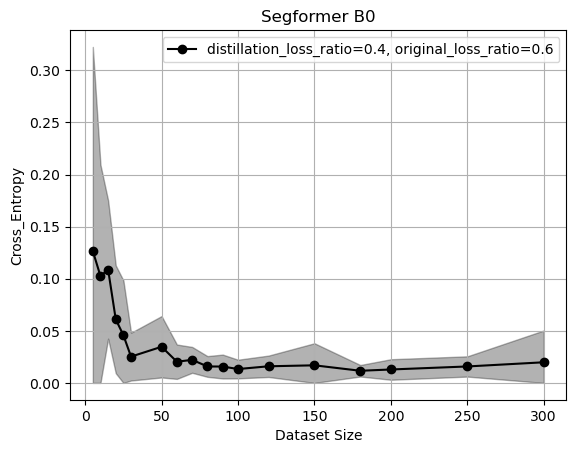

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()